<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#读取数据" data-toc-modified-id="读取数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>读取数据</a></span></li><li><span><a href="#根据业务理解及常识添加一些特征" data-toc-modified-id="根据业务理解及常识添加一些特征-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>根据业务理解及常识添加一些特征</a></span></li><li><span><a href="#缺失值处理" data-toc-modified-id="缺失值处理-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>缺失值处理</a></span></li><li><span><a href="#异常值处理" data-toc-modified-id="异常值处理-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>异常值处理</a></span><ul class="toc-item"><li><span><a href="#特征转换——日期特征转化为时长特征" data-toc-modified-id="特征转换——日期特征转化为时长特征-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>特征转换——日期特征转化为时长特征</a></span></li></ul></li><li><span><a href="#特征转换——对类别变量进行编码" data-toc-modified-id="特征转换——对类别变量进行编码-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>特征转换——对类别变量进行编码</a></span></li><li><span><a href="#数据标准化" data-toc-modified-id="数据标准化-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>数据标准化</a></span></li><li><span><a href="#根据数据及算法添加特征" data-toc-modified-id="根据数据及算法添加特征-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>根据数据及算法添加特征</a></span></li><li><span><a href="#特征选择&amp;特征提取" data-toc-modified-id="特征选择&amp;特征提取-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>特征选择&amp;特征提取</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Stacking-Method" data-toc-modified-id="Stacking-Method-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Stacking Method</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from feature_selector import FeatureSelector
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier,StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns',200)

/Users/fanzhang/opt/anaconda3/envs/chinatelecom/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## 读取数据

In [2]:
# 加载产品实例信息
prd_data = pd.read_csv('../赛题数据文件-20191224135916164/prd_data.csv',encoding='utf-8')

# 加载通话信息、个人信息、DPI信息、终端信息和训练集标签数据
call_data = pd.read_csv('../赛题数据文件-20191224135916164/call_data.csv',encoding='utf-8')
cust_data = pd.read_csv('../赛题数据文件-20191224135916164/cust_data.csv',encoding='utf-8')
dpi_data = pd.read_csv('../赛题数据文件-20191224135916164/dpi_data.csv',encoding='utf-8')
trmnl_data = pd.read_csv('../赛题数据文件-20191224135916164/trmnl_data_update.csv',encoding='utf-8')
train_label = pd.read_csv('../赛题数据文件-20191224135916164/train_result.csv',encoding='utf-8')

# 以产品实例信息为主表，关联其余信息表，生成原始数据宽表
all_data = pd.merge(prd_data, call_data, how='left', on='user')

all_data = pd.merge(all_data, cust_data, how='left', on='user')
all_data = pd.merge(all_data, dpi_data, how='left', on='user')
all_data = pd.merge(all_data, trmnl_data, how='left', on='user')
all_data = pd.merge(all_data, train_label, how='left', on='user')

## 根据业务理解及常识添加一些特征

In [3]:
all_data['feature1'] = 0
all_data.loc[all_data['dt_m_1004']>5*all_data['dt_m_1004'].median(),'feature1'] = 1
all_data.loc[all_data['dt_m_1004']>10*all_data['dt_m_1004'].median(),'feature1'] = 2
all_data.loc[all_data['dt_m_1004']>20*all_data['dt_m_1004'].median(),'feature1'] = 3
all_data['feature2'] = 0
all_data.loc[all_data['dt_m_1006']>5*all_data['dt_m_1006'].median(),'feature2'] = 1
all_data.loc[all_data['dt_m_1006']>10*all_data['dt_m_1006'].median(),'feature2'] = 2
all_data.loc[all_data['dt_m_1006']>20*all_data['dt_m_1006'].median(),'feature2'] = 3
all_data['feature3'] = 0
all_data.loc[all_data['dt_m_1011']<0.5*all_data['dt_m_1011'].median(),'feature3'] = 1
all_data.loc[all_data['dt_m_1011']<0.1*all_data['dt_m_1011'].median(),'feature3'] = 2
all_data.loc[all_data['dt_m_1011']<0.05*all_data['dt_m_1011'].median(),'feature3'] = 3
all_data['feature4'] = 0
all_data.loc[all_data['dt_m_1012']<0.5*all_data['dt_m_1012'].median(),'feature4'] = 1
all_data.loc[all_data['dt_m_1012']<0.1*all_data['dt_m_1012'].median(),'feature4'] = 2
all_data.loc[all_data['dt_m_1012']<0.05*all_data['dt_m_1012'].median(),'feature4'] = 3
all_data['feature5'] = 0
all_data.loc[all_data['dt_m_1017']>5*all_data['dt_m_1017'].median(),'feature5'] = 1
all_data.loc[all_data['dt_m_1017']>10*all_data['dt_m_1017'].median(),'feature5'] = 2
all_data.loc[all_data['dt_m_1017']>20*all_data['dt_m_1017'].median(),'feature5'] = 3
all_data['feature6'] = 0
all_data.loc[all_data['dt_m_1028']>5,'feature6'] = 1
all_data.loc[all_data['dt_m_1028']>10,'feature6'] = 2
all_data.loc[all_data['dt_m_1028']>20,'feature6'] = 3
all_data['feature7'] = 0
all_data.loc[all_data['dt_m_1027']<3,'feature7'] = 1
all_data.loc[all_data['dt_m_1027']<2,'feature7'] = 2
all_data.loc[all_data['dt_m_1027']<1,'feature7'] = 3
all_data['feature8'] = 0
all_data.loc[all_data['dt_m_1032']>0.5,'feature8'] = 1
all_data.loc[all_data['dt_m_1032']>0.75,'feature8'] = 2
all_data.loc[all_data['dt_m_1032']>0.9,'feature8'] = 3
all_data['feature9'] = 0
all_data.loc[(all_data['dt_m_1032']+all_data['dt_m_1034']+all_data['dt_m_1035'])/3>0.5,'feature9'] = 1
all_data.loc[(all_data['dt_m_1032']+all_data['dt_m_1034']+all_data['dt_m_1035'])/3>0.75,'feature9'] = 2
all_data.loc[(all_data['dt_m_1032']+all_data['dt_m_1034']+all_data['dt_m_1035'])/3>0.9,'feature9'] = 3

all_data['feature10'] = 0
all_data.loc[all_data['dt_m_1041']>5*all_data['dt_m_1041'].median(),'feature10'] = 1
all_data.loc[all_data['dt_m_1041']>10*all_data['dt_m_1041'].median(),'feature10'] = 2
all_data.loc[all_data['dt_m_1041']>20*all_data['dt_m_1041'].median(),'feature10'] = 3
all_data['feature11'] = 0
all_data.loc[all_data['dt_m_1043']>5*all_data['dt_m_1043'].median(),'feature11'] = 1
all_data.loc[all_data['dt_m_1043']>10*all_data['dt_m_1043'].median(),'feature11'] = 2
all_data.loc[all_data['dt_m_1043']>20*all_data['dt_m_1043'].median(),'feature11'] = 3
all_data['feature12'] = 0
all_data.loc[all_data['dt_m_1051']/all_data['dt_m_1041']>0.5,'feature12'] = 1
all_data.loc[all_data['dt_m_1051']/all_data['dt_m_1041']>0.75,'feature12'] = 2
all_data.loc[all_data['dt_m_1051']/all_data['dt_m_1041']>0.9,'feature12'] = 3
all_data['feature13'] = 0
all_data.loc[all_data['dt_m_1052']/all_data['dt_m_1043']>0.5,'feature13'] = 1
all_data.loc[all_data['dt_m_1052']/all_data['dt_m_1043']>0.75,'feature13'] = 2
all_data.loc[all_data['dt_m_1052']/all_data['dt_m_1043']>0.9,'feature13'] = 3

all_data['feature14'] = 0
all_data.loc[all_data['dt_m_1067']>5*all_data['dt_m_1067'].median(),'feature14'] = 1
all_data.loc[all_data['dt_m_1067']>10*all_data['dt_m_1067'].median(),'feature14'] = 2
all_data.loc[all_data['dt_m_1067']>20*all_data['dt_m_1067'].median(),'feature14'] = 3
all_data['feature15'] = 0
all_data.loc[all_data['dt_m_1068']>5*all_data['dt_m_1068'].median(),'feature15'] = 1
all_data.loc[all_data['dt_m_1068']>10*all_data['dt_m_1068'].median(),'feature15'] = 2
all_data.loc[all_data['dt_m_1068']>20*all_data['dt_m_1068'].median(),'feature15'] = 3

all_data['feature16'] = 0
all_data.loc[all_data['dt_m_1073']>5*all_data['dt_m_1073'].median(),'feature16'] = 1
all_data.loc[all_data['dt_m_1073']>10*all_data['dt_m_1073'].median(),'feature16'] = 2
all_data.loc[all_data['dt_m_1073']>20*all_data['dt_m_1073'].median(),'feature16'] = 3
all_data['feature17'] = 0
all_data.loc[all_data['dt_m_1074']>5*all_data['dt_m_1074'].median(),'feature17'] = 1
all_data.loc[all_data['dt_m_1074']>10*all_data['dt_m_1074'].median(),'feature17'] = 2
all_data.loc[all_data['dt_m_1074']>20*all_data['dt_m_1074'].median(),'feature17'] = 3
all_data['feature18'] = 0
all_data.loc[all_data['dt_m_1075']>5*all_data['dt_m_1075'].median(),'feature18'] = 1
all_data.loc[all_data['dt_m_1075']>10*all_data['dt_m_1075'].median(),'feature18'] = 2
all_data.loc[all_data['dt_m_1075']>20*all_data['dt_m_1075'].median(),'feature18'] = 3

all_data['feature19'] = 0
all_data.loc[all_data['dt_m_1085']>0.5,'feature19'] = 1
all_data.loc[all_data['dt_m_1085']>0.75,'feature19'] = 2
all_data.loc[all_data['dt_m_1085']>0.9,'feature19'] = 3
all_data['feature20'] = 0
all_data.loc[all_data['dt_m_1086']>0.5,'feature20'] = 1
all_data.loc[all_data['dt_m_1086']>0.75,'feature20'] = 2
all_data.loc[all_data['dt_m_1086']>0.9,'feature20'] = 3
all_data['feature21'] = 0
all_data.loc[all_data['dt_m_1087']>0.5,'feature21'] = 1
all_data.loc[all_data['dt_m_1087']>0.75,'feature21'] = 2
all_data.loc[all_data['dt_m_1087']>0.9,'feature21'] = 3

all_data['feature22'] = 0
all_data.loc[all_data['dt_m_1617']<0.5*all_data['dt_m_1617'].median(),'feature22'] = 1
all_data.loc[all_data['dt_m_1617']<0.1*all_data['dt_m_1617'].median(),'feature22'] = 2
all_data.loc[all_data['dt_m_1617']<0.01*all_data['dt_m_1617'].median(),'feature22'] = 3
all_data['feature23'] = 0
all_data.loc[all_data['dt_m_1618']<10*24*3600,'feature23'] = 1
all_data.loc[all_data['dt_m_1618']<24*3600,'feature23'] = 2
all_data.loc[all_data['dt_m_1618']<3600,'feature23'] = 3
all_data['feature24'] = 0
all_data.loc[all_data['dt_m_1620']<0.1*all_data['dt_m_1620'].median(),'feature24'] = 1
all_data.loc[all_data['dt_m_1620']<0.01*all_data['dt_m_1620'].median(),'feature24'] = 2
all_data.loc[all_data['dt_m_1620']<0.001*all_data['dt_m_1620'].median(),'feature24'] = 3

all_data['feature25'] = 0
all_data.loc[
    all_data['dt_m_1633']/(all_data['dt_m_1633']+all_data['dt_m_1630']+0.01)<
    0.1*(all_data['dt_m_1633']/(all_data['dt_m_1633']+all_data['dt_m_1630']+0.01)).median(),'feature25'] = 1
all_data.loc[
    all_data['dt_m_1633']/(all_data['dt_m_1633']+all_data['dt_m_1630']+0.01)<
    0.05*(all_data['dt_m_1633']/(all_data['dt_m_1633']+all_data['dt_m_1630']+0.01)).median(),'feature25'] = 2
all_data.loc[
    all_data['dt_m_1633']/(all_data['dt_m_1633']+all_data['dt_m_1630']+0.01)<
    0.01*(all_data['dt_m_1633']/(all_data['dt_m_1633']+all_data['dt_m_1630']+0.01)).median(),'feature25'] = 3

all_data['feature26'] = 0
all_data.loc[all_data['dt_m_1096']>10*all_data['dt_m_1096'].median(),'feature26'] = 1
all_data.loc[all_data['dt_m_1096']>50*all_data['dt_m_1096'].median(),'feature26'] = 2
all_data.loc[all_data['dt_m_1096']>100*all_data['dt_m_1096'].median(),'feature26'] = 3

all_data['feature27'] = 0
all_data.loc[all_data['dt_m_1102']>10*all_data['dt_m_1102'].median(),'feature27'] = 1
all_data.loc[all_data['dt_m_1102']>50*all_data['dt_m_1102'].median(),'feature27'] = 2
all_data.loc[all_data['dt_m_1102']>100*all_data['dt_m_1102'].median(),'feature27'] = 3

all_data['feature28'] = 0
all_data.loc[all_data['dt_m_1108']>10*all_data['dt_m_1108'].median(),'feature28'] = 1
all_data.loc[all_data['dt_m_1108']>50*all_data['dt_m_1108'].median(),'feature28'] = 2
all_data.loc[all_data['dt_m_1108']>100*all_data['dt_m_1108'].median(),'feature28'] = 3

all_data['feature29'] = 0
all_data.loc[all_data['dt_m_1594']>10,'feature29'] = 1
all_data.loc[all_data['dt_m_1594']>20,'feature29'] = 2
all_data.loc[all_data['dt_m_1594']>=28,'feature29'] = 3

all_data['feature30'] = 0
all_data.loc[all_data['dt_m_1601']>10,'feature30'] = 1
all_data.loc[all_data['dt_m_1601']>50,'feature30'] = 2
all_data.loc[all_data['dt_m_1601']>100,'feature30'] = 3

In [4]:
try_list = ['app1_visits', 'app2_visits', 'app3_visits', 'app4_visits',
            'app5_visits', 'app6_visits', 'app7_visits', 'app8_visits']
all_data['try_col']=0
for i in try_list:
    all_data['try_col']+=all_data[i]
all_data['try_col'] = all_data['try_col'].apply(lambda x: 1 if x>0 else 0)

In [5]:
all_data.loc[all_data['dt_m_1041']>all_data['dt_m_1043'],'dt_m_1043'
            ] = all_data[all_data['dt_m_1041']>all_data['dt_m_1043']]['dt_m_1041']

all_data.loc[all_data['dt_m_1051']>all_data['dt_m_1052'],'dt_m_1052'
            ] = all_data[all_data['dt_m_1051']>all_data['dt_m_1052']]['dt_m_1051']

all_data.loc[all_data['dt_m_1067']>all_data['dt_m_1068'],'dt_m_1068'
            ] = all_data[all_data['dt_m_1067']>all_data['dt_m_1068']]['dt_m_1067']

# 本月10s内主叫通话次数
all_data['add_col1'] = all_data['dt_m_1006']*all_data['dt_m_1032']
# 本月30s内主叫通话次数
all_data['add_col2'] = all_data['dt_m_1006']*all_data['dt_m_1034']
# 本月1min内主叫通话次数
all_data['add_col3'] = all_data['dt_m_1006']*all_data['dt_m_1035']

# 本月7-18点工作时段主叫通话次数
all_data['add_col4'] = all_data['dt_m_1006']*all_data['dt_m_1085']
# 本月18-22点晚间时段主叫通话次数
all_data['add_col5'] = all_data['dt_m_1006']*all_data['dt_m_1086']
# 本月22-07点凌晨时段主叫通话次数
all_data['add_col6'] = all_data['dt_m_1006']*all_data['dt_m_1087']

for col_name in ['add_col1', 'add_col2', 'add_col3', 'add_col4', 'add_col5', 'add_col6']:
    all_data[col_name] = all_data[col_name].apply(lambda x: round(x,0))  

# 本月7-18点工作时段被叫通话次数
all_data['add_col10'] = all_data['dt_m_1073']-all_data['add_col4']
# 本月18-22点工作时段被叫通话次数
all_data['add_col11'] = all_data['dt_m_1074']-all_data['add_col5']
# 本月22-07点工作时段被叫通话次数
all_data['add_col12'] = all_data['dt_m_1075']-all_data['add_col6']


# 本月通话人数占近三个月通话人数比
all_data['add_col7'] = all_data['dt_m_1041']/all_data['dt_m_1043']
# 本月主叫通话人数占近3个月主叫通话人数比
all_data['add_col8'] = all_data['dt_m_1051']/all_data['dt_m_1052']
# 本月主叫对端号码区域分布个数占近3个月主叫对端号码区域分布个数比
all_data['add_col9'] = all_data['dt_m_1067']/all_data['dt_m_1068']

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402164 entries, 0 to 402163
Columns: 108 entries, user to add_col9
dtypes: float64(38), int64(64), object(6)
memory usage: 334.4+ MB


In [7]:
all_data.select_dtypes(include=['object']).columns

Index(['user', 'product_nbr', 'pro_brand', 'term_model', 'register_date',
       'label'],
      dtype='object')

In [8]:
all_data['credit_level'].unique()

array([ 1.00100e+05, -1.00000e+00,  9.99999e+05,  1.00200e+05,
        1.10100e+05,  1.00400e+05,          nan,  1.00300e+05])

## 缺失值处理

In [9]:
# 缺失值处理应该结合数据分布及对数据的理解来进行。
#为简化，本次演示中把APP访问次数类的字段缺失值都填充为0，其余都处理为-1，。
col_fill0 = ['app1_visits', 'app2_visits', 'app3_visits', 'app4_visits', 'app5_visits', 'app6_visits', 
             'app7_visits', 'app8_visits', 'cust_point']
for col in col_fill0:
    imp = SimpleImputer(fill_value=0,add_indicator=True)
    res = imp.fit_transform(all_data[[col]])
    all_data[col] = res[:,0]
    all_data[col+'_indicator'] = res[:,1]
    
col_fill1 = ['cust_access_net_dt','birth_date','open_date',
             'membership_level','star_level', 'market_price', 'inet_pd_inst_cnt']
for col in col_fill1:
    imp = SimpleImputer(strategy='median',add_indicator=True)
    res = imp.fit_transform(all_data[[col]])
    all_data[col] = res[:,0]
    all_data[col+'_indicator'] = res[:,1]

# col_fill3 = ['credit_level', 'gender', 'pro_brand', 'term_model', 'register_date',]
all_data = all_data.fillna(-1)

In [10]:
# # 缺失值处理应该结合数据分布及对数据的理解来进行。
# #为简化，本次演示中把APP访问次数类的字段缺失值都填充为0，其余都处理为-1，。
# col_fill0 = ['app1_visits', 'app2_visits', 'app3_visits', 'app4_visits', 'app5_visits', 'app6_visits', 
#              'app7_visits', 'app8_visits', 'cust_point']
# for col in col_fill0:
#     all_data[col].fillna(0, inplace=True)
    
# col_fill1 = ['cust_access_net_dt','birth_date','open_date',
#              'membership_level','star_level', 'market_price', 'inet_pd_inst_cnt']
# for col in col_fill1:
#     replace_val = all_data[col][-all_data[col].isnull()].median()
#     all_data[col].fillna(replace_val, inplace=True)

# # col_fill3 = ['credit_level', 'gender', 'pro_brand', 'term_model', 'register_date',]
# all_data = all_data.fillna(-1)

## 异常值处理

In [11]:
min_value_list = ['dt_m_1043','dt_m_1052', 'dt_m_1068', 'dt_m_1618','dt_m_1620','credit_level','gender','cust_point']
for col in min_value_list:
    all_data.loc[all_data[col]<0,col]=all_data.loc[all_data[col]>0,col].median()
    
col_outlier1 = ['app1_visits', 'app2_visits', 'app3_visits', 'app4_visits', 'app5_visits', 
                'app6_visits', 'app7_visits', 'app8_visits',
                'dt_m_1000', 'dt_m_1003', 'dt_m_1004', 'dt_m_1005', 'dt_m_1006', 'dt_m_1009', 
                'dt_m_1011', 'dt_m_1012', 'dt_m_1015', 'dt_m_1017', 'dt_m_1041', 'dt_m_1043', 
                'dt_m_1051', 'dt_m_1052', 'dt_m_1073', 'dt_m_1074', 'dt_m_1075', 'dt_m_1096', 
                'dt_m_1099', 'dt_m_1102', 'dt_m_1105', 'dt_m_1108', 'dt_m_1111', 'dt_m_1617', 
                'dt_m_1620', 'dt_m_1630', 'dt_m_1633']
threshood1 = [17,47,15,30161,2554,597,4466,3951,1102.85,62065.85,2010.580645,7566.85,872,
             40081,5728,306,26203,4046.85,719,1299,684,93,928,157,42,272,20512.85,224,16153.7,46,
             5074,141,37141.47629,34,89]


for i in range(len(col_outlier1)):
    col_name = col_outlier1[i]
    thres = threshood1[i]
    all_data.loc[all_data[col_name]>thres,col_name]=thres

all_data.loc[all_data['inet_pd_inst_cnt']>10,'inet_pd_inst_cnt']=all_data['inet_pd_inst_cnt'].median()

### 特征转换——日期特征转化为时长特征

In [12]:
from datetime import datetime,timedelta
import time
def months(str1,str2):
    if len(str2)==6:
        str1_d = datetime.strptime(str1, "%Y%m")
        str2_d = datetime.strptime(str2, "%Y%m")
        num=(str1_d.year-str2_d.year)*12+(str1_d.month-str2_d.month)
    elif len(str2)==7:
        str1_d = datetime.strptime(str1, "%Y%m")
        str2_d = datetime.strptime(str2, "%Y-%m")
        num = (str1_d.year-str2_d.year)*12+(str1_d.month-str2_d.month)
    else:
        num=-1
    return num

In [13]:
# 简化起见，把开通日期在20190930以后的异常值替换为该列中位数
all_data.loc[all_data['open_date']>20190930,'open_date']=20190930

all_data.loc[all_data['birth_date']>20190808,'birth_date']=20190808
all_data.loc[all_data['birth_date']<19781001,'birth_date']=19781001

all_data.loc[all_data['cust_access_net_dt']<1.978e13,'cust_access_net_dt']=1.9781001e13

all_data['cust_access_net_dt_year'] = all_data['cust_access_net_dt'].apply(lambda x:int(str(x)[0:4]))
all_data['cust_access_net_dt_month'] = all_data['cust_access_net_dt'].apply(lambda x:int(str(x)[4:6]))

all_data['register_date_year'] = all_data['register_date'].apply(lambda x:int(str(x)[0:4]))
all_data['register_date_month'] = all_data['register_date'].apply(lambda x:int(str(x)[5:7]) if str(x)[5:7]!='' else 1)

all_data['open_date_year'] = all_data['open_date'].apply(lambda x:int(str(x)[0:4]))
all_data['open_date_month'] = all_data['open_date'].apply(lambda x:int(str(x)[4:6]))

# 对客户入网时间、出生日期、终端自注册短信发送时间、用户的开通日期做此类处理。
all_data['cust_access_net_dt']=all_data['cust_access_net_dt'].apply(lambda x:months('201910',str(x)[0:6]))
all_data['birth_date']=all_data['birth_date'].apply(lambda x:months('201910',str(x)[0:6]))
all_data['register_date']=all_data['register_date'].apply(lambda x:months('201910',str(x)[0:7]))
all_data['open_date']=all_data['open_date'].apply(lambda x:months('201910',str(x)[0:6]))

all_data['try_col2'] = all_data['open_date'] - all_data['cust_access_net_dt']
all_data['try_col2'] = all_data['try_col2'].apply(lambda x: 1 if x>0 else 0)

all_data['try_col3'] = all_data['open_date'] - all_data['register_date']
all_data['try_col3'] = all_data['try_col3'].apply(lambda x: 1 if x>0 else 0)

all_data['try_col4'] = 0
all_data.loc[(all_data['open_date']>11) & (all_data['last_year_capture_user_flag']==1),'try_col4']=1

all_data.loc[all_data['register_date']==-1,'register_date'] = all_data.loc[all_data['register_date']!=-1,'register_date'].median()

all_data['cust_point_avg']=all_data['cust_point']/all_data['cust_access_net_dt']

all_data.loc[all_data['cust_point']>14919,'cust_point']=14919

## 特征转换——对类别变量进行编码

In [14]:
le_credit_level = LabelEncoder().fit(all_data['credit_level'])
all_data['credit_level'] = le_credit_level.transform(all_data['credit_level'])

#会员等级、星级级别做同样处理
le_membership_level = LabelEncoder().fit(all_data['membership_level'])
all_data['membership_level'] = le_membership_level.transform(all_data['membership_level'])

le_star_level = LabelEncoder().fit(all_data['star_level'])
all_data['star_level'] = le_star_level.transform(all_data['star_level'])

# all_data['membership_level'] = LabelEncoder().fit_transform(all_data['membership_level'])


le_label = LabelEncoder().fit(all_data['label'][all_data['label']!= -1])   #可能需要把-1改成'-1'

le_label.classes_

le_label.transform(all_data['label'][all_data['label']!= -1])

all_data.loc[all_data['label']!= -1,'label'] = le_label.transform(all_data['label'][all_data['label']!= -1])

term_model = pd.DataFrame({'total':all_data[['user','term_model']
                                           ].groupby('term_model').size().sort_values(ascending=False)})

all_data['term_model'] = all_data['term_model'].apply(lambda x:term_model.at[x,'total'] if x!=-1 else -1)

term_model = pd.DataFrame({'total':all_data[['user','pro_brand']
                                           ].groupby('pro_brand').size().sort_values(ascending=False)})

all_data['pro_brand'] = all_data['pro_brand'].apply(lambda x:term_model.at[x,'total'] if x!=-1 else -1)

In [15]:
term_model = pd.DataFrame({'total':all_data[['user','term_model']
                                           ].groupby('term_model').size().sort_values(ascending=False)})

all_data['term_model'] = all_data['term_model'].apply(lambda x:term_model.at[x,'total'] if x!=-1 else -1)

term_model = pd.DataFrame({'total':all_data[['user','pro_brand']
                                           ].groupby('pro_brand').size().sort_values(ascending=False)})

all_data['pro_brand'] = all_data['pro_brand'].apply(lambda x:term_model.at[x,'total'] if x!=-1 else -1)

In [18]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402164 entries, 0 to 402163
Columns: 134 entries, user to cust_point_avg
dtypes: float64(60), int64(72), object(2)
memory usage: 414.2+ MB


In [19]:
all_data.select_dtypes(include=['float64','int64']).columns

Index(['dt_m_1000', 'dt_m_1003', 'dt_m_1004', 'dt_m_1005', 'dt_m_1017',
       'dt_m_1032', 'dt_m_1034', 'dt_m_1035', 'dt_m_1043', 'dt_m_1052',
       'dt_m_1068', 'dt_m_1085', 'dt_m_1086', 'dt_m_1087', 'dt_m_1099',
       'dt_m_1105', 'dt_m_1618', 'dt_m_1620', 'gender', 'cust_point',
       'inet_pd_inst_cnt', 'app1_visits', 'app2_visits', 'app3_visits',
       'app4_visits', 'app5_visits', 'app6_visits', 'app7_visits',
       'app8_visits', 'register_date', 'market_price', 'add_col1', 'add_col2',
       'add_col3', 'add_col4', 'add_col5', 'add_col6', 'add_col10',
       'add_col11', 'add_col12', 'add_col7', 'add_col8', 'add_col9',
       'app1_visits_indicator', 'app2_visits_indicator',
       'app3_visits_indicator', 'app4_visits_indicator',
       'app5_visits_indicator', 'app6_visits_indicator',
       'app7_visits_indicator', 'app8_visits_indicator',
       'cust_point_indicator', 'cust_access_net_dt_indicator',
       'birth_date_indicator', 'open_date_indicator',
       'member

In [17]:
all_data['label'].unique()

array([ 2, -1,  3,  1,  4,  0])

## 数据标准化

In [13]:
## 选出需要进行标准化的特征
scale_columns = all_data.select_dtypes(include=['float64','int64']).columns

len(scale_columns)

#删掉其中无需标准化的属性，包括：数据为类别编码类、占比类
scale_columns = scale_columns.drop(['dt_m_1032', 'dt_m_1034', 'dt_m_1035', 
                                    'dt_m_1085', 'dt_m_1086', 'dt_m_1087',
                                    'gender'])


#定义标准化函数
min_max_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))

#在需要进行标准化的列上执行该函数
all_data[scale_columns]=all_data[scale_columns].apply(min_max_scaler)

all_data[scale_columns].head()

,dt_m_1000,dt_m_1003,dt_m_1004,dt_m_1005,dt_m_1017,dt_m_1043,dt_m_1052,dt_m_1068,dt_m_1099,dt_m_1105,dt_m_1618,dt_m_1620,cust_point,inet_pd_inst_cnt,app1_visits,app2_visits,app3_visits,app4_visits,app5_visits,app6_visits,app7_visits,app8_visits,register_date,market_price,add_col1,add_col2,add_col3,add_col4,add_col5,add_col6,add_col10,add_col11,add_col12,add_col7,add_col8,add_col9,app1_visits_indicator,app2_visits_indicator,app3_visits_indicator,app4_visits_indicator,app5_visits_indicator,app6_visits_indicator,app7_visits_indicator,app8_visits_indicator,cust_point_indicator,cust_access_net_dt_indicator,birth_date_indicator,open_date_indicator,membership_level_indicator,star_level_indicator,market_price_indicator,inet_pd_inst_cnt_indicator,cust_point_avg
0,0.213471,0.234960,0.233972,0.212902,0.366952,0.144838,0.956522,0.018809,0.068591,0.016219,0.009743,0.071127,0.387559,0.2,0.0,0.000000,0.0,0.554159,0.040329,1.000000,0.001120,0.003797,0.037267,0.145416,0.003812,0.004369,0.005415,0.008011,0.003650,0.000652,0.019678,0.012101,0.002201,0.407218,0.359346,0.713216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000207
1,0.056320,0.064399,0.064128,0.121979,0.213746,0.012327,0.065217,0.000000,0.008872,0.000000,0.001027,0.025860,0.306388,0.4,0.0,0.000000,0.0,0.025563,0.050509,0.000000,0.000000,0.024045,0.118012,0.036320,0.000381,0.001066,0.001977,0.002963,0.000664,0.000652,0.004803,0.001650,0.000000,0.705788,0.714194,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000237
2,0.466004,0.508992,0.506851,0.463601,0.490752,0.132512,0.934783,0.018809,0.058451,0.073172,0.019394,0.094323,0.000000,0.4,0.0,0.000000,0.0,0.199894,0.337510,0.068677,0.000000,0.035687,0.006211,0.149961,0.003241,0.007032,0.011346,0.014156,0.013935,0.003262,0.039046,0.039054,0.011739,0.618375,0.609071,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.446927,0.409565,0.407842,0.468359,0.261685,0.157165,1.000000,0.015674,0.083704,0.106291,0.015343,0.137678,0.040887,0.4,1.0,0.430525,1.0,0.313997,0.247531,0.198783,0.171513,0.241200,0.000000,0.145416,0.003241,0.011934,0.015558,0.018545,0.018248,0.013046,0.028819,0.024202,0.014674,0.380290,0.385631,0.498127,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000019
4,0.337921,0.509636,0.507493,0.598796,0.286643,0.087057,1.000000,0.031348,0.140595,0.165473,0.002607,0.045678,0.000000,0.3,0.0,0.000000,0.0,0.117702,0.001175,0.000000,0.037394,0.009871,0.000000,0.113551,0.000953,0.006819,0.011776,0.021947,0.019244,0.003262,0.013015,0.012101,0.003668,0.447192,0.456137,0.543752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## 根据数据及算法添加特征

In [20]:
for i in all_data.columns:
    print(i)

user
product_nbr
open_date
last_year_capture_user_flag
dt_m_1000
dt_m_1003
dt_m_1004
dt_m_1005
dt_m_1006
dt_m_1009
dt_m_1011
dt_m_1012
dt_m_1015
dt_m_1017
dt_m_1027
dt_m_1028
dt_m_1032
dt_m_1034
dt_m_1035
dt_m_1041
dt_m_1043
dt_m_1051
dt_m_1052
dt_m_1067
dt_m_1068
dt_m_1073
dt_m_1074
dt_m_1075
dt_m_1085
dt_m_1086
dt_m_1087
dt_m_1096
dt_m_1099
dt_m_1102
dt_m_1105
dt_m_1108
dt_m_1111
dt_m_1594
dt_m_1601
dt_m_1617
dt_m_1618
dt_m_1620
dt_m_1630
dt_m_1633
cust_access_net_dt
credit_level
membership_level
gender
birth_date
cust_point
inet_pd_inst_cnt
star_level
app1_visits
app2_visits
app3_visits
app4_visits
app5_visits
app6_visits
app7_visits
app8_visits
pro_brand
term_model
register_date
market_price
label
feature1
feature2
feature3
feature4
feature5
feature6
feature7
feature8
feature9
feature10
feature11
feature12
feature13
feature14
feature15
feature16
feature17
feature18
feature19
feature20
feature21
feature22
feature23
feature24
feature25
feature26
feature27
feature28
feature29
feature3

In [15]:
selected_data = all_data[['dt_m_1000', 'dt_m_1003', 'dt_m_1004', 'dt_m_1005', 'dt_m_1006',
       'dt_m_1009', 'dt_m_1011', 'dt_m_1012', 'dt_m_1015', 'dt_m_1017',
       'dt_m_1027', 'dt_m_1028', 'dt_m_1032', 'dt_m_1034', 'dt_m_1035',
       'dt_m_1041', 'dt_m_1043', 'dt_m_1051', 'dt_m_1052', 'dt_m_1067',
       'dt_m_1068', 'dt_m_1073', 'dt_m_1074', 'dt_m_1075', 'dt_m_1085',
       'dt_m_1086', 'dt_m_1087', 'dt_m_1096', 'dt_m_1099', 'dt_m_1102',
       'dt_m_1105', 'dt_m_1108', 'dt_m_1111', 'dt_m_1594', 'dt_m_1601',
       'dt_m_1617', 'dt_m_1618', 'dt_m_1620', 'dt_m_1630', 'dt_m_1633']]
selected_data2 = all_data[['app1_visits', 'app2_visits', 'app3_visits', 'app4_visits',
       'app5_visits', 'app6_visits', 'app7_visits', 'app8_visits']]
selected_data3 = all_data[['cust_access_net_dt', 'credit_level', 'membership_level', 'gender',
       'birth_date', 'cust_point', 'inet_pd_inst_cnt', 'star_level','register_date', 'market_price',
       'cust_access_net_dt_year', 'cust_access_net_dt_month',
       'register_date_year', 'register_date_month', 'open_date_year',
       'open_date_month', 'try_col2', 'try_col3', 'try_col4',
       'cust_point_avg','open_date', 'last_year_capture_user_flag']]
selected_data4 = all_data[['app1_visits_indicator', 'app2_visits_indicator',
       'app3_visits_indicator', 'app4_visits_indicator',
       'app5_visits_indicator', 'app6_visits_indicator',
       'app7_visits_indicator', 'app8_visits_indicator',
       'cust_point_indicator', 'cust_access_net_dt_indicator',
       'birth_date_indicator', 'open_date_indicator',
       'membership_level_indicator', 'star_level_indicator',
       'market_price_indicator', 'inet_pd_inst_cnt_indicator']]
selected_data5 = all_data[['add_col1','add_col2','add_col3','try_col',
                       'add_col4','add_col5','add_col6','add_col10','add_col11','add_col12','feature1','feature2',
                       'feature3','feature4','feature5','feature6','feature7','feature8','feature9','feature10',
                       'feature11','feature12','feature13','feature14','feature15','feature16','feature17',
                       'feature18','feature19','feature20','feature21','feature22','feature23','feature24',
                       'feature25','feature26','feature27','feature28','feature29','feature30']]

In [21]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(selected_data)
all_data['pca_selected_data_col2']=X_reduced[:,1]
all_data['pca_selected_data_col1']=X_reduced[:,0]

X_reduced = pca.fit_transform(selected_data2)
all_data['pca_selected_data2_col1']=X_reduced[:,0]
all_data['pca_selected_data2_col2']=X_reduced[:,1]
all_data['pca_selected_data2_col3']=X_reduced[:,2]
all_data['pca_selected_data2_col4']=X_reduced[:,3]
all_data['pca_selected_data2_col5']=X_reduced[:,4]
all_data['pca_selected_data2_col6']=X_reduced[:,5]
all_data['pca_selected_data2_col7']=X_reduced[:,6]

X_reduced = pca.fit_transform(selected_data3)
all_data['pca_selected_data3_col2']=X_reduced[:,1]
all_data['pca_selected_data3_col1']=X_reduced[:,0]

X_reduced = pca.fit_transform(selected_data4)
all_data['pca_selected_data4_col2']=X_reduced[:,1]
all_data['pca_selected_data4_col1']=X_reduced[:,0]

X_reduced = pca.fit_transform(selected_data5)
(_, num) = X_reduced.shape
for i in range(num):
    all_data['pca_selected_data_col'+str(i)]=X_reduced[:,i]

In [22]:
gmm = GaussianMixture(n_components=5)

gmm_reduced = gmm.fit(selected_data).predict(selected_data)
all_data['gmm_selected_data']=gmm_reduced

gmm_reduced = gmm.fit(selected_data2).predict(selected_data2)
all_data['gmm_selected_data2']=gmm_reduced

gmm_reduced = gmm.fit(selected_data3).predict(selected_data3)
all_data['gmm_selected_data3']=gmm_reduced

In [23]:
tsne = TSNE(n_components=3)
result = tsne.fit_transform(selected_data)

tsne = TSNE(n_components=3,verbose=True)
result2 = tsne.fit_transform(selected_data2)

In [124]:
all_data['tsne_selected_data_col1'] = result[:,0]
all_data['tsne_selected_data_col2'] = result[:,1]
all_data['tsne_selected_data_col3'] = result[:,2]

all_data['tsne_selected_data2_col1'] = result2[:,0]
all_data['tsne_selected_data2_col2'] = result2[:,1]
all_data['tsne_selected_data2_col3'] = result2[:,2]

## 特征选择&特征提取

In [125]:
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,classification_report

45 features with a correlation magnitude greater than 0.90.



['dt_m_1004',
 'dt_m_1006',
 'dt_m_1009',
 'dt_m_1041',
 'dt_m_1043',
 'dt_m_1051',
 'dt_m_1068',
 'dt_m_1073',
 'dt_m_1102',
 'dt_m_1105',
 'feature2',
 'feature6',
 'feature10',
 'feature11',
 'feature15',
 'feature16',
 'feature19',
 'feature23',
 'feature24',
 'feature27',
 'feature29',
 'add_col2',
 'add_col3',
 'add_col4',
 'add_col8',
 'app1_visits_indicator',
 'app2_visits_indicator',
 'app3_visits_indicator',
 'app4_visits_indicator',
 'app5_visits_indicator',
 'app6_visits_indicator',
 'app7_visits_indicator',
 'app8_visits_indicator',
 'cust_access_net_dt_indicator',
 'membership_level_indicator',
 'star_level_indicator',
 'inet_pd_inst_cnt_indicator',
 'cust_access_net_dt_year',
 'register_date_year',
 'open_date_year',
 'pca_selected_data_col2',
 'pca_selected_data2_col1',
 'pca_selected_data3_col1',
 'pca_selected_data4_col2',
 'pca_selected_data4_col1']

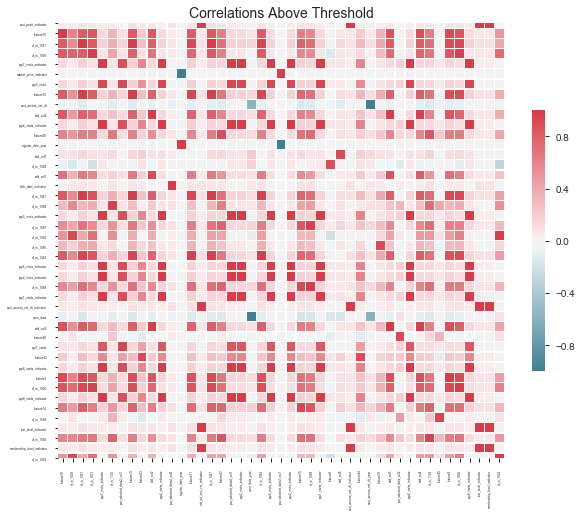

In [162]:
#拆分数据
train_data = all_data[all_data['label']>-1]
test_data = all_data[all_data['label']==-1]

train_labels = train_data['label']
train_features = train_data.drop(columns=['user', 'product_nbr','last_year_capture_user_flag','label'])

fs = FeatureSelector(data=train_features, labels=train_labels)
fs.identify_collinear(correlation_threshold = 0.9,one_hot=False)
# 绘制选择的特征的相关性heatmap
fs.plot_collinear()
# 列出要删除的共线特征
collinear_features = fs.ops['collinear']
# 查看共线特征的dataframe
fs.record_collinear

train_data = train_data.drop(columns=collinear_features)

collinear_features

In [163]:
X=train_data.drop(['label','user','product_nbr'],axis=1)
# X=train_data.drop(['label','user'],axis=1)
y=train_data['label']
# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 / 4., random_state=22)

## LightGBM

In [128]:
def rate(data):
    print(len(data.loc[data.label==0])/len(data.loc[data.label==0]),len(data.loc[data.label==0])/len(data.loc[data.label==1]),len(data.loc[data.label==0])/len(data.loc[data.label==2]),len(data.loc[data.label==0])/len(data.loc[data.label==3]),len(data.loc[data.label==0])/len(data.loc[data.label==4]))


rate(train_data)

1.0 1.2052713870895688 0.038146946335531944 0.6058836739276892 4.706498037505451


In [129]:
model = LGBMClassifier(objective='multiclass',boosting_type='gbdt', num_leaves=100, max_depth=10, 
                       learning_rate=0.1, 
                       n_estimators=1200,num_class=5, class_weight={0:1,1:1.205,2:0.038,3:0.606,4:4.706}, 
                       min_child_weight=6,min_child_samples=12, subsample=0.8, subsample_freq=2, 
                       colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=0.2, random_state=25, n_jobs=-1)
clf_best = model.fit(X_train, y_train)

y_train_pred = clf_best.predict(X_train)
y_test_pred = clf_best.predict(X_test)
print('\nTrain Classification report:\n',classification_report(y_train,y_train_pred))
print('\nTest Classification report:\n',classification_report(y_test,y_test_pred))

In [131]:
file_name = 'pred_20200213_00000.csv'
pred_data = test_data.drop(columns=collinear_features)
X_pred = pred_data.drop(['label','user','product_nbr'],axis=1)    
y_pred = clf_best.predict(X_pred)

y_pred = le_label.inverse_transform(y_pred)

test_data['pred_label'] = y_pred
test_data[['user','pred_label']].to_csv(file_name,encoding = 'utf-8',index = None, header = None)

/Users/fanzhang/opt/anaconda3/envs/chinatelecom/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


---

**以下会得到更好结果，但是运算量会很大，请查验上方结果是否可以，如可以，就不必执行下面的融合模型。**

---

## Stacking Method

In [157]:
# LogisticRegression
lr = LogisticRegression(penalty='l2', C=1, multi_class='multinomial',solver="newton-cg",n_jobs=-1)

# 决策树
dt = DecisionTreeClassifier(criterion='entropy',max_depth=10,max_leaf_nodes=40,min_samples_leaf=1,
                            min_samples_split=2,random_state=30,class_weight={0:1,1:1.205,2:0.038,3:0.606,4:4.706})

# SVM
svm = SVC(random_state=2018,max_iter=5000,probability=True,decision_function_shape='ovo')

# 随机森林
rfc = RandomForestClassifier(criterion='entropy',max_depth=10,max_leaf_nodes=40,
                             n_estimators=1200, random_state=2018,n_jobs=-1,
                             class_weight={0:1,1:1.205,2:0.038,3:0.606,4:4.706})

# GBDT
gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.1, n_estimators=1200)

# xgboost
xgbc = XGBClassifier(learning_rate=0.1, objective= 'multi:softmax', max_depth=10, n_estimators=1200,n_jobs=-1,
                    num_class=5, class_weight={0:1,1:1.205,2:0.038,3:0.606,4:4.706})

# # lightgbm
lgbc = LGBMClassifier(objective='multiclass',boosting_type='gbdt', num_leaves=100, max_depth=10, learning_rate=0.1, 
                       n_estimators=1200,num_class=5, class_weight={0:1,1:1.205,2:0.038,3:0.606,4:4.706}, 
                       min_child_weight=6,min_child_samples=12, subsample=0.8, subsample_freq=2, 
                       colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=0.2, random_state=25, n_jobs=-1)

knc = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)

gauss = GaussianNB()

In [159]:
sclf = StackingCVClassifier(classifiers=[lgbc,rfc,lr,dt,svm,gbc,xgbc,knc,gauss],
                            use_probas=True,
                            meta_classifier=lr,
                            random_state=42,
                            verbose=1,
                            cv=2,
                            n_jobs=-1)
# 定义一个包含多个评价指标的函数
sclf.fit(X_train, y_train)

Fitting 4 classifiers...
Fitting classifier1: lgbmclassifier (1/4)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier2: randomforestclassifier (2/4)


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  7.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting classifier3: logisticregression (3/4)
Fitting classifier4: decisiontreeclassifier (4/4)


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s finished


StackingCVClassifier(classifiers=[LGBMClassifier(boosting_type='gbdt',
                                                 class_weight={0: 1, 1: 1.205,
                                                               2: 0.038,
                                                               3: 0.606,
                                                               4: 4.706},
                                                 colsample_bytree=0.8,
                                                 importance_type='split',
                                                 learning_rate=0.1,
                                                 max_depth=10,
                                                 min_child_samples=12,
                                                 min_child_weight=6,
                                                 min_split_gain=0.0,
                                                 n_estimators=1200, n_jobs=-1,
                                                 num_class=5, num_

In [160]:
y_train_pred = sclf.predict(X_train)
y_test_pred = sclf.predict(X_test)
print('\nTrain Classification report:\n',classification_report(y_train,y_train_pred))
print('\nTest Classification report:\n',classification_report(y_test,y_test_pred))


Train Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8035
           1       0.98      0.99      0.98      6709
           2       1.00      1.00      1.00    212282
           3       0.97      0.97      0.97     13323
           4       0.90      0.91      0.91      1718

    accuracy                           0.99    242067
   macro avg       0.97      0.97      0.97    242067
weighted avg       0.99      0.99      0.99    242067


Test Classification report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83      2757
           1       0.92      0.89      0.90      2245
           2       0.99      0.99      0.99     70624
           3       0.86      0.90      0.88      4489
           4       0.73      0.80      0.76       575

    accuracy                           0.97     80690
   macro avg       0.88      0.87      0.87     80690
weighted avg    

In [164]:
file_name = 'pred_20200215_2.csv'
pred_data = test_data.drop(columns=collinear_features)
X_pred = pred_data.drop(['label','user','product_nbr'],axis=1)    
y_pred = sclf.predict(X_pred)

y_pred = le_label.inverse_transform(y_pred)

test_data['pred_label'] = y_pred
test_data[['user','pred_label']].to_csv(file_name,encoding = 'utf-8',index = None, header = None)

/Users/fanzhang/opt/anaconda3/envs/chinatelecom/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
f1_list = [3.40487829,0.08222349,0.00549958,0.0222378,0.00122172]
z = 0
for i in f1_list:    
    x = np.sqrt(i)/10
    y = 5*x/(2-x)
    print(x, y)
    z+=y
    print(z)

0.1845231229412726 0.5081946382049779
0.5081946382049779
0.028674638620216297 0.07272934032600825
0.5809239785309861
0.007415915317747365 0.0186087888956765
0.5995327674266626
0.014912343880155124 0.03756092038097593
0.6370936878076385
0.0034953111449483295 0.0087535760984183
0.6458472639060568


In [ ]:
 GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 12,
    cv = 4,
    verbose=True
)

In [ ]:
1006/1000, 1012/1000, 1041/1000, 1051/1000, 1073/1000, 1074/1000, 1096/1000, 
1102/1000, 1108/1000, 

1005/1003, 1009/1003, 1011/1003, 1015/1003, 1017/1003, 
1099/1003, 1105/1003, 

1003/1005, 1009/1005, 1011/1005, 1015/1005, 1017/1005, 1099/1005, 

1051/1006, 1102/1006,

1011/1009, 1105/1009,

1009/1011,

1017/1015, 1111/1015

1015/1017,

1051/1041, 

1052/1043, 

1067/1051,

1594/1067,

1003/1068, 1108/1068, 1594/1068,

1102/1096, 1108/1096,

1105/1099, 1111/1099,

In [ ]:
1027,1028,1034,1035,1085,1086,1594

In [ ]:
1006/1000, 1012/1000, '1027/1000', '1028/1000', 1041/1000, 1051/1000, 1073/1000, 1074/1000
1096/1000, 1102/1000, 1108/1000, '1594/1000'

1005/1003, 1009/1003, 1011/1003, 1015/1003, 1017/1003, 1099/1003, 1105/1003

1003/1005, 1009/1005, 1011/1005, 1015/1005, 1017/1005, 1099/1005, "1105/1005", "1111/1005"

1051/1006, "1067/1006", 1102/1006

1011/1009, 1105/1009

1009/1011, "1105/1011", 

1017/1015, 1111/1015
1015/1017, "1111/1017"

'1000/1027, 1006/1027, 1015/1027, 1017/1027, 1028/1027, 1041/1027, 1043/1027, '
'1051/1027, 1052/1027, 1067/1027, 1068/1027, 1073/1027, 1074/1027, 1594/1027, 1620/1027'

'1000/1028, 1003/1028, 1004/1028, 1006/1028, 1017/1028, 1027/1028, 1068/1028, 1073/1028
'1074/1028, 1099/1028, 1105/1028, 1111/1028, 1594/1028, 1620/1028

1051/1041, "1067/1041"

1052/1043, 1067/1051

"1068/1052"

'1027/1067, 1028/1067,' 1594/1067,

1003/1068, '1027/1068, 1028/1068', 1108/1068, 1594/1068

'1000/1075, 1003/1075, 1006/1075, 1009/1075, 1027/1075, 1028/1075, 1041/1075,
'1043/1075, 1051/1075, 1052/1075, 1067/1075, 1068/1075, 1073/1075, 1074/1075, 1096/1075

'1027/1096, 1028/1096,' 1102/1096, 1108/1096

'1027/1099, 1028/1099,' 1105/1099, 1111/1099

'1027/1102, 1028/1102'

'1027/1105, 1028/1105'

'1000/1108, 1006/1108, 1017/1108, 1027/1108, 1028/1108, 1041/1108, 
'1043/1108, 1051/1108, 1052/1108, 1067/1108, 1068/1108, 1073/1108, 1074/1108,
'1096/1108, 1102/1108, 1594/1108, 1618/1108, 1620/1108

'1000/1111, 1006/1111, 1015/1111, 1017/1111, 1027/1111, 1028/1111, 1041/1111, 
'1043/1111, 1051/1111, 1052/1111, 1067/1111, 1068/1111, 1073/1111, 1074/1111, 1594/1111

'1000/1594, 1006/1594, 1017/1594, 1027/1594, 1028/1594, 1041/1594, 1043/1594, 1051/1594,
'1052/1594, 1067/1594, 1068/1594, 1073/1594, 1074/1594, 1102/1594, 1601/1594, 1618/1594, 
'1620/1594

'1000/1601, 1006/1601, 1017/1601, 1027/1601, 1028/1601, 1041/1601, 1043/1601, 
'1051/1601, 1052/1601, 1067/1601, 1068/1601, 1073/1601

'1000/1617, 1006/1617, 1017/1617, 1027/1617, 1028/1617, 1041/1617, 1043/1617,
'1051/1617, 1052/1617, 1067/1617, 1068/1617, 1073/1617, 1074/1617, 1096/1617, 1102/1617

'1000/1630, 1004/1630, 1015/1630, 1017/1630, 1027/1630, 1028/1630, 1041/1630, 
'1043/1630, 1051/1630, 1052/1630, 1067/1630, 1068/1630, 1073/1630, 1074/1630, 
'1096/1630, 1102/1630, 1594/1630, 1601/1630

'1000/1633, 1004/1633, 1005/1633, 1006/1633, 1015/1633, 1017/1633, 1027/1633, 
'1028/1633, 1041/1633, 1043/1633, 1051/1633, 1052/1633, 1067/1633, 1068/1633, 
'1073/1633, 1074/1633, 1096/1633, 1102/1633, 1594/1633, 1620/1633

In [ ]:
thresh = {'dt_m_1003':143,'dt_m_1004':0.464,'dt_m_1005':14,
          'dt_m_1006':5826.0,'dt_m_1009':102,'dt_m_10011':9,'dt_m_1012':2473,
          'dt_m_1015':44,'dt_m_1017':7,'dt_m_1041':4800,'dt_m_1042':9,
          'dt_m_1043':12000,'dt_m_1051':8000,'dt_m_1052':8833,'dt_m_1073':5362,
         'dt_m_1075':940,'dt_m_1096':3393,'dt_m_1099':63,'dt_m_1102':3393,
         'dt_m_1105':84,'dt_m_1108':850,'dt_m_1601':28,'dt_m_1617':1753,'dt_m_1618':14070,
         'dt_m_1620':123686,'dt_m_1630':7829,'dt_m_1633':2817}